In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# Lightly adapted from https://github.com/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb

# Automatically generating object masks with SAM

Since SAM 2 can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image.

The class `SAM2AutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/sam2/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Environment Set-up

If running locally using jupyter, first install `SAM 2` in your environment using the installation instructions in the repository.

If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'. Note that it's recommended to use **A100 or L4 GPUs when running in Colab** (T4 GPUs might also work, but could be slow and might run out of memory in some cases).

In [1]:
using_colab = False

## Set-up

In [213]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageOps

In [3]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [152]:
def show_anns(base_img, anns, borders=True):
    if len(anns) == 0:
        return

    np.random.seed(3)

    plt.figure(figsize=(20, 20))
    plt.imshow(base_img)
    
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 

    ax.imshow(img)
    plt.axis('off')
    plt.show() 

In [193]:
masks[0]['segmentation'].astype(np.uint8).max()

np.uint8(1)

In [236]:
def show_anns2(base_img, anns, borders=True):
    if len(anns) == 0:
        return

    np.random.seed(3)

    image = Image.fromarray(base_img)
    for ann in anns:
        mask = Image.fromarray(ann['segmentation'].astype(np.uint8) * 128)
        edged_mask = edged_mask = Image.blend(mask, mask.filter(ImageFilter.EDGE_ENHANCE), 0.5)
        color = (255 * np.random.random(3)[None, None, :]).astype(np.uint8)
        color_image = Image.fromarray(np.ones_like(base_img) * color)
        image = Image.composite(color_image, image, edged_mask)
        
    return image

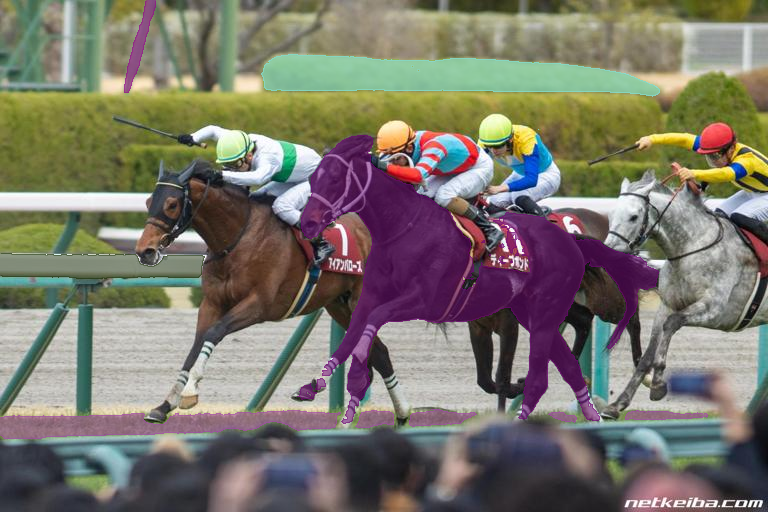

In [237]:
show_anns2(image, masks)

## Example image

In [107]:
image = Image.open('images/horses.jpg')
image = np.array(image.convert("RGB"))

## Automatic mask generation

To run automatic mask generation, provide a version of SAM 2 to the `SAM2AutomaticMaskGenerator` class. Set the path below to the SAM 2 checkpoint.

In [7]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/s
am2.1/sam2.1_hiera_l.yaml"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

mask_generator = SAM2AutomaticMaskGenerator(sam2)

In [71]:
np.random.seed(3)
import matplotlib.patches as patches

def show_bboxs(image, masks):
    if len(masks) == 0:
        return
    
    plt.figure(figsize=(20, 20))
    ax = plt.gca()
    ax.imshow(image)
    ax.set_autoscale_on(False)
    w = image.shape[1]
    h = image.shape[0]
    for mask in masks:
        bbox = mask['bbox']
        r = patches.Rectangle(xy=(bbox[0], bbox[1]), width=bbox[2], height=bbox[3], ec=np.random.random(3), fill=False, lw=3.0)
        ax.add_patch(r)
    
    plt.axis('off')
    plt.show() 

In [159]:
mask_generator = SAM2AutomaticMaskGenerator(
    sam2,
    points_per_side = 3,
    points_per_batch = 64,
    pred_iou_thresh = 0.8,
    stability_score_thresh = 0.75,
    stability_score_offset = 1.0,
    mask_threshold = 0.0,
    box_nms_thresh = 0.7,
    crop_n_layers = 0,
    crop_nms_thresh = 0.7,
    crop_overlap_ratio = 512 / 1500,
    crop_n_points_downscale_factor = 1,
    point_grids = None,
    min_mask_region_area = 0,
    output_mode = "binary_mask",
    use_m2m = False,
    multimask_output = True,
)
masks = mask_generator.generate(image)

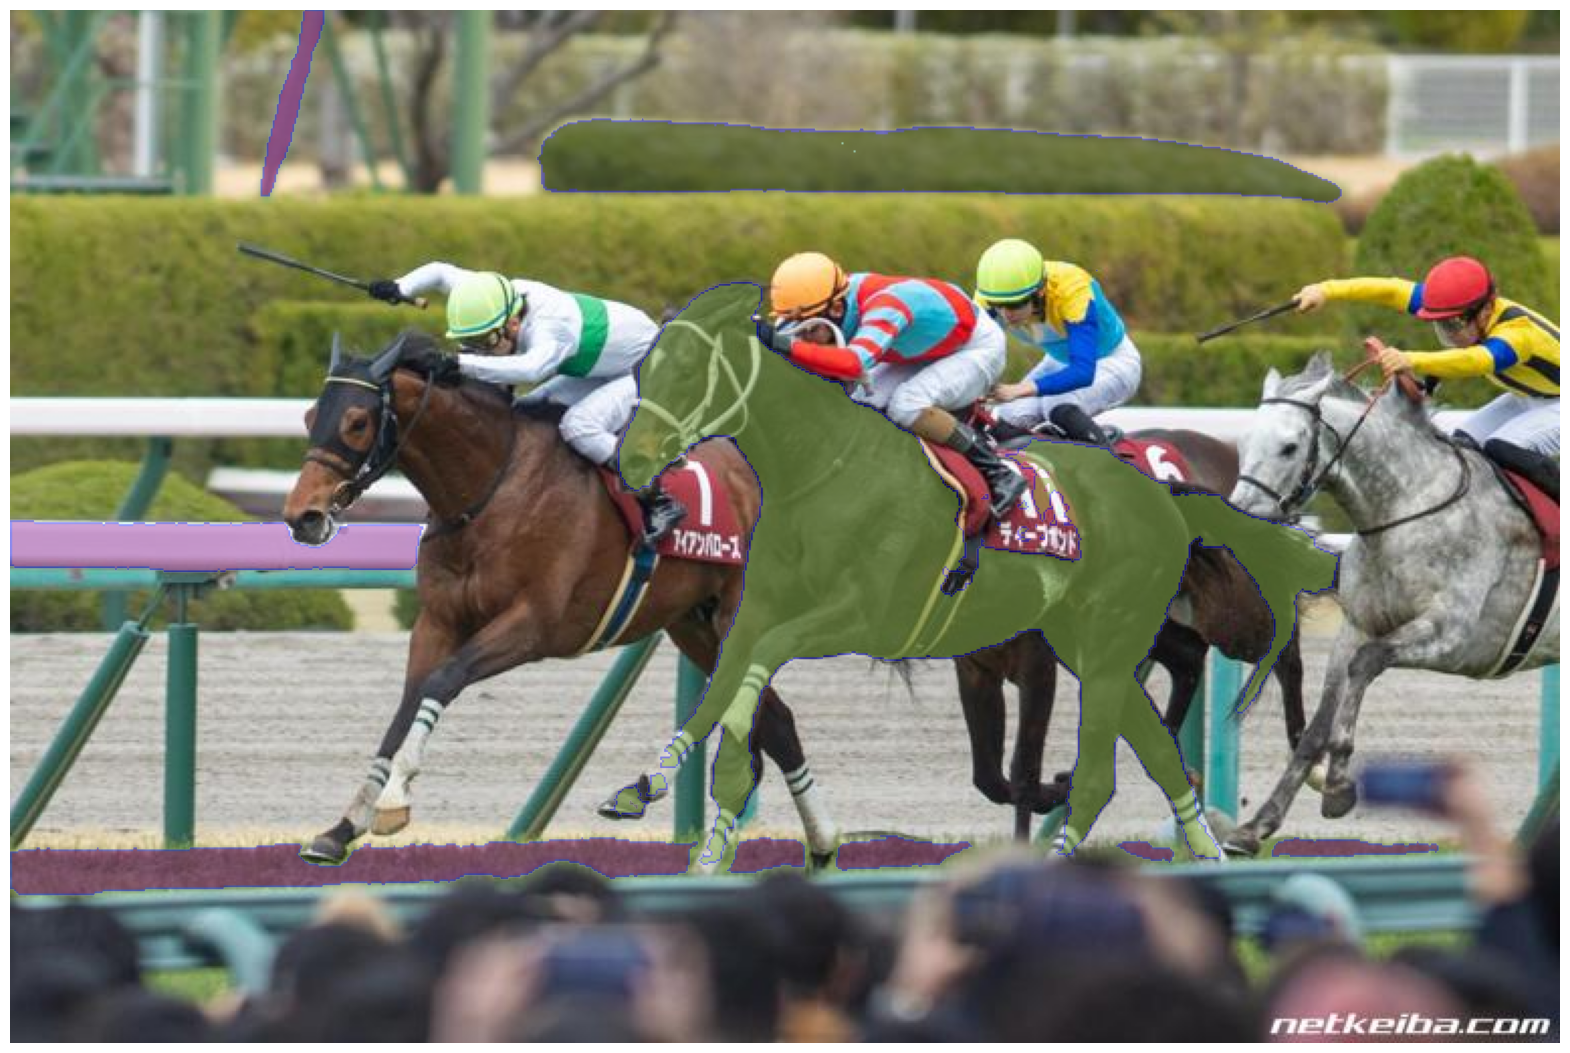

In [160]:
show_anns(image, masks)

126
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


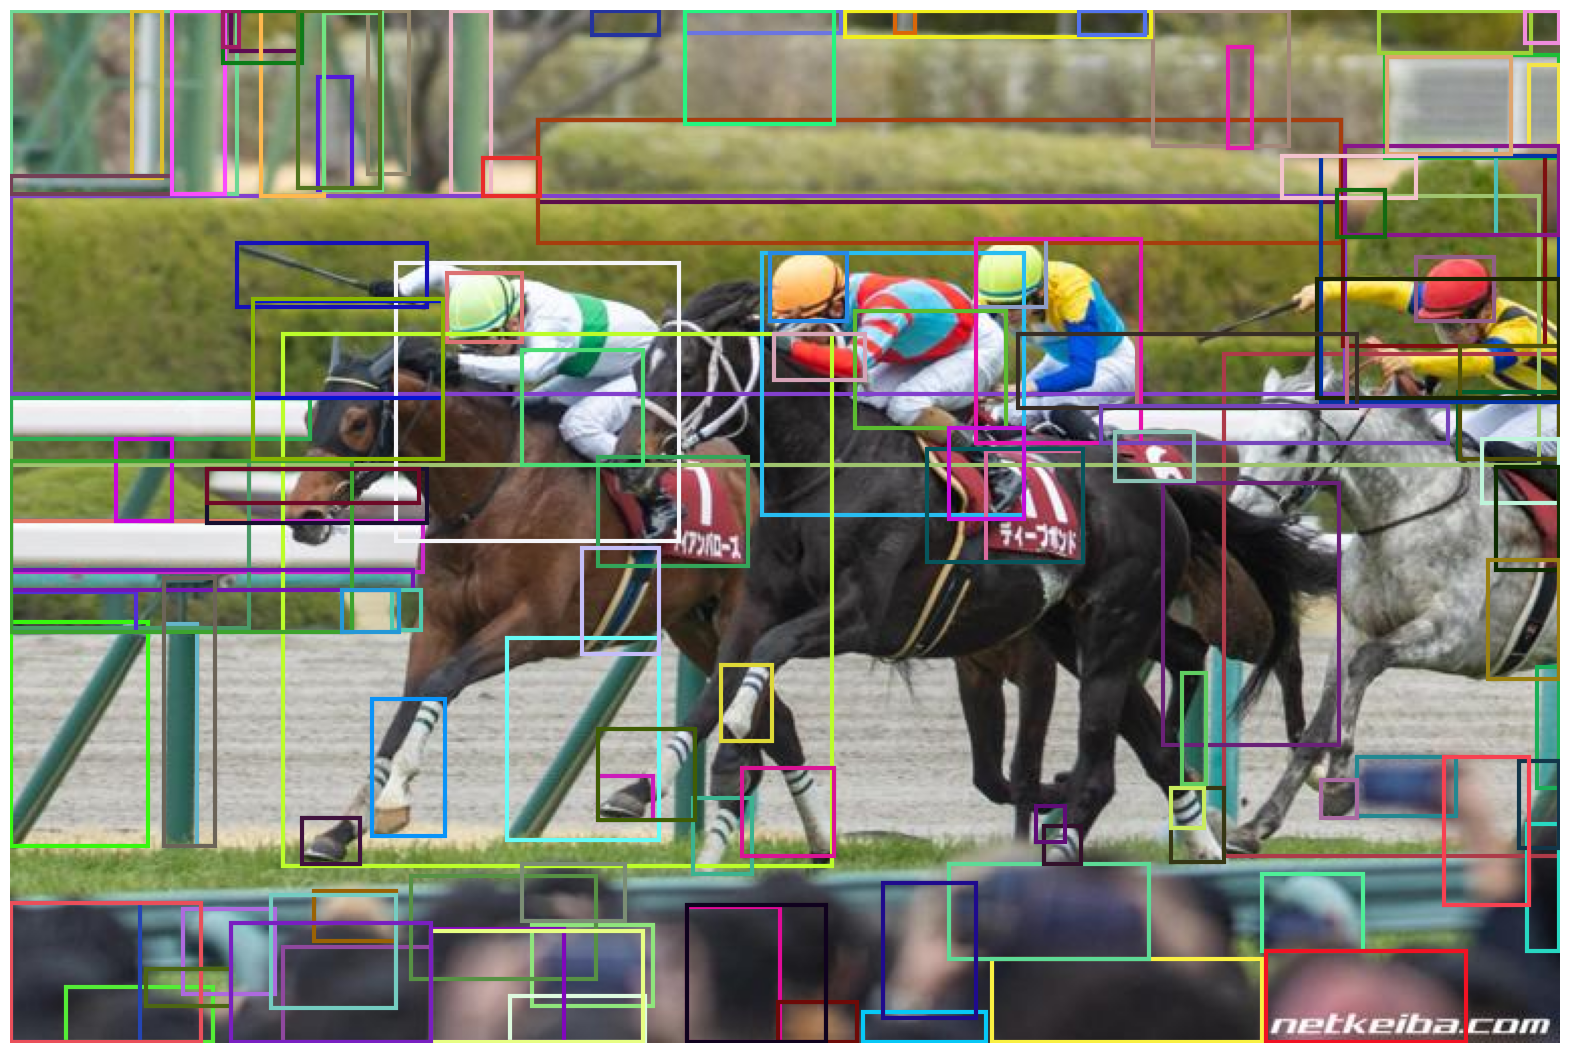

In [144]:
print(len(masks))
print(masks[0].keys())

show_bboxs(image, masks)

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [11]:
mask_generator_2 = SAM2AutomaticMaskGenerator(
    model=sam2,
    points_per_side=64,
    points_per_batch=128,
    pred_iou_thresh=0.7,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=1,
    box_nms_thresh=0.7,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=25.0,
    use_m2m=True,
)

In [12]:
masks2 = mask_generator_2.generate(image)

/mnt/c/Users/reins/workspace/sam2/sam2/sam2_image_predictor.py:431: UserWarning: cannot import name '_C' from 'sam2' (/mnt/c/Users/reins/workspace/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  masks = self._transforms.postprocess_masks(


In [14]:
print(len(masks2))
print(masks2[0].keys())

726
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


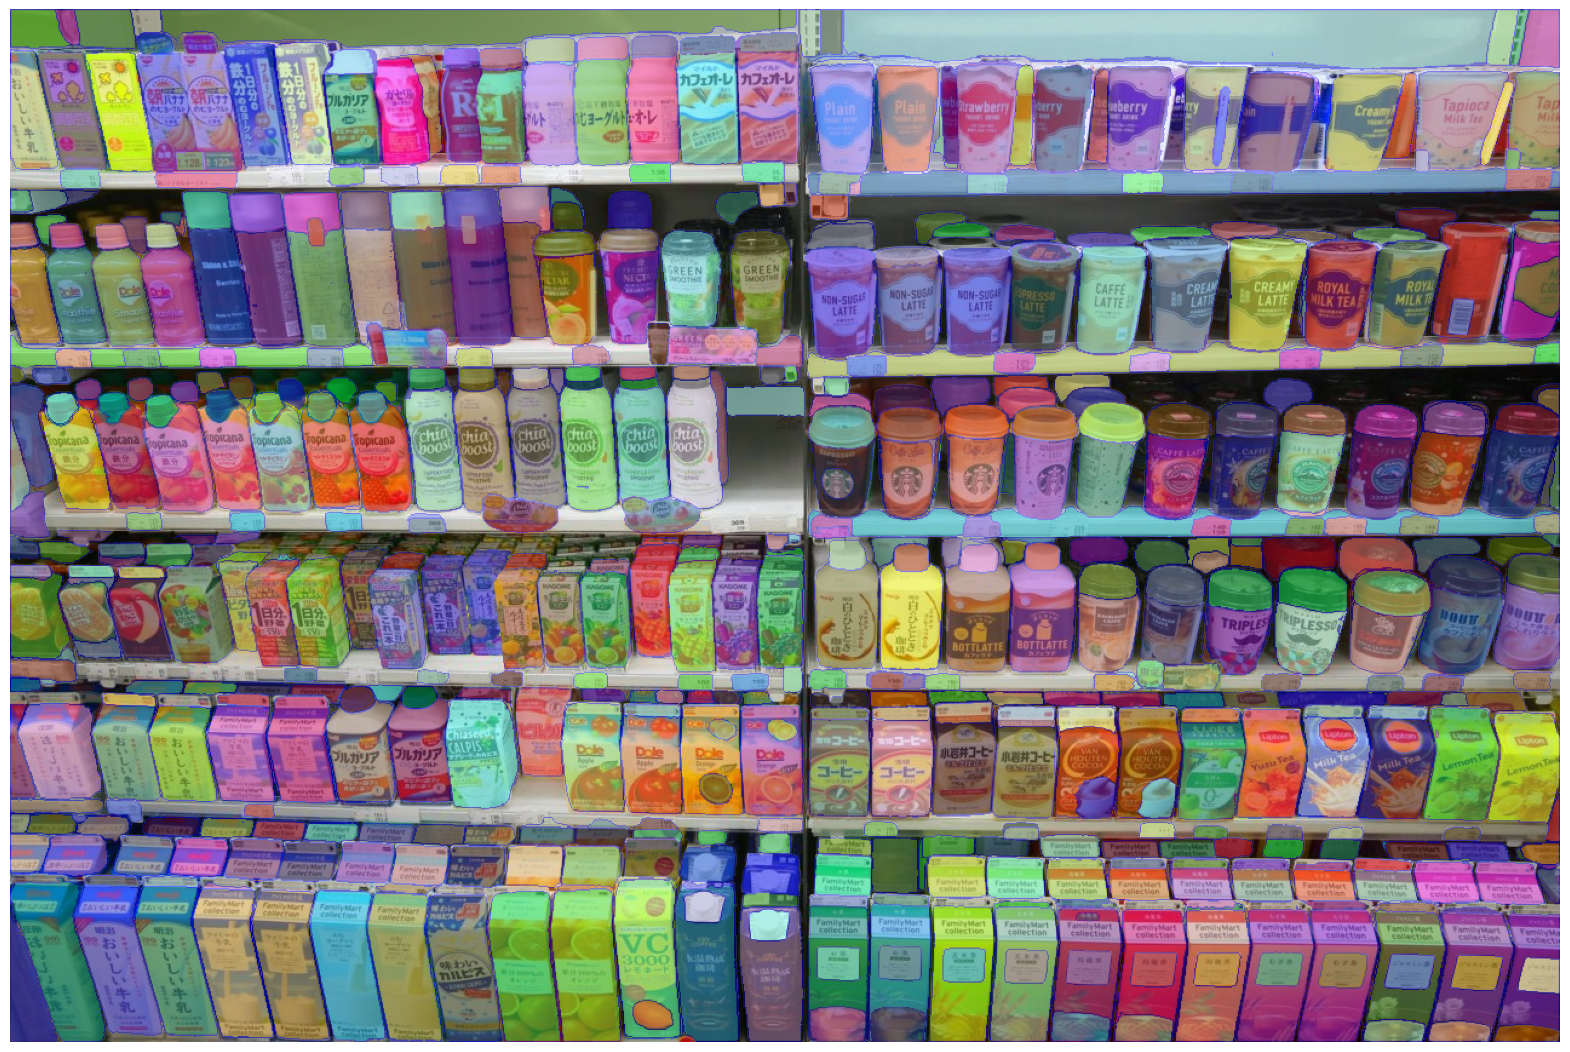

In [13]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show() 